# FasterR-CNN Training

## Table of contents
1. [Dataframes import](#df)<br>
2. [Dataset import](#dataset)<br>
3. [Albumentations](#alb)<br>
4. [Dataloaders](#datal)<br>
    4.1 [Colored images](#col_img)<br>
    4.2 [BW images](#bw_img)<br>
    4.3 [Undersampled images](#under_img)<br>
    4.4 [Oversampled images](#over_img)<br>
5. [Training](#tr)<br>
    5.1 [Base Colored Model](#aug_m)<br>
    5.2 [BW Model](#bw_m)<br>
    5.3 [Undersampled Model](#under_m)<br>
    5.4 [Oversampled Model](#over_m)<br>

In [1]:
# importing libraries
import pandas as pd
import json
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sn
import numpy as np
from PIL import Image
import torchvision
from typing_extensions import Concatenate
from torch.utils.data.sampler import Sampler
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations.pytorch
import albumentations
import cv2
import time
import torch
import pickle
from tqdm.notebook import tqdm

## FasterR-CNN Model and Device

In [2]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")  
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## 1. Importing Dataframes <a class="anchor" id="df"></a>
We import the validation and test dataframes preprocessed in the ```Preprocessing.ipynb``` notebook in order to have seperate dataframes for validation and test set, with the respective ```catgory_id```, ```identifier```.  

In [3]:
# importing training dataframe
file = open("pickles/train.pickle", "rb")
train_df_final = pickle.load(file)
file.close()   
train_df_final.head()

,license,file_name,rights_holder,height,width,id,area,iscrowd,image_id,bbox,category_id,id_y,identifier,category_name,super_category_name
142644,6,train_val_images/Aves/Ardea alba/a69b1a629f606...,Luis Romero,451,800,217350,23034.0,0,217350,"[141, 31, 132, 349]",1,156404,a69b1a629f606f18fcec54a2009f2a07.jpg,Ardea alba,Aves
296416,1,train_val_images/Aves/Buteo jamaicensis/c3b2a7...,Mark,533,800,422794,57224.0,0,422794,"[217, 76, 311, 368]",3,325612,c3b2a77d90cf0d44bfbec38362d898d2.jpg,Buteo jamaicensis,Aves
401615,3,train_val_images/Aves/Cardinalis cardinalis/00...,Linda Jo,800,762,563025,66720.0,0,563025,"[292, 213, 320, 417]",7,438762,0067fdd047d9c24e5409c545dacdc673.jpg,Cardinalis cardinalis,Aves
288776,5,train_val_images/Aves/Picoides pubescens/cd27b...,Fluff Berger,800,696,412818,53530.0,0,412818,"[285, 204, 202, 530]",8,317222,cd27b0ccacc613687a449dd7c0627025.jpg,Picoides pubescens,Aves
390920,3,train_val_images/Aves/Ardea alba/e68368329b589...,lorax32,800,600,549762,2743.5,0,549762,"[159, 114, 59, 93]",1,427436,e68368329b589f10cb0ea15d7f511508.jpg,Ardea alba,Aves


## 2. Dataset Class <a class="anchor" id="dataset"></a>
We import here all the functions and classes contained in the ```dataset.py``` file.
Here below a brief explanation of the classes we have implemented:
- ```AvesAugmentationDataset```: customized dataset class that satisfied our needs for the augmentations we will perform.
- ```AvesStochAugDataset```: customized dataset class needed for the dataset we will use for the under-sampled and over-sampled models.
- ```SATMsampler```: customized sampler class for obtaining balanced class in the sampler.

In [4]:
from SATM.dataset import AvesAugmentationDataset, SATMsampler, AvesStochAugDataset
from SATM.dataset import collate_fn, generate_box, generate_target, plot_image_from_output

## 3. Albumentations <a class="anchor" id="alb"></a>
Since our goal is object detection, it is not sufficient to use the standard torch transformations, but we need to use the Albumentations package. [Albumentations](https://albumentations.ai/) is a Python library for fast and flexible image augmentations. One of its main advantages is that it makes it possible to transform boxes according to the image transformation. Below are all the transformations we want to apply to our dataframe, some of which are geometrical (HorizontalFlip, Rotate), and the remaining ones at pixels level. Each of these has a parameter ```p``` indicating the probability with which that transformation will be applied. To apply these transformations to our dataset, we have implemented the ```AvesAugmentationDataset``` class shown before.

In [5]:
# transformations we want to implement
transformations = [albumentations.MotionBlur(blur_limit=3, p=0.1),
                    albumentations.Blur(blur_limit=3, p=0.1),
                    albumentations.RandomBrightnessContrast(brightness_limit=0.2, p=0.1),
                    albumentations.ColorJitter(p=0.5),
                    albumentations.RandomGamma(p=0.2),
                    albumentations.RandomFog(p=0.5,fog_coef_upper= 0.5),
                    albumentations.MedianBlur(blur_limit=3, p=0.1),
                    albumentations.HorizontalFlip(p=0.5),
                    albumentations.Rotate(p=0.5)]

## 4. Dataloaders <a class="anchor" id="dl"></a>

### 4.1 Dataloader - Colored images <a class="anchor" id="col_img"></a>
To create the dataloader for the colored images, we decide to add in our dataset 2 albumentations augmentations while also keeping the original image (using the ```num_aug``` parameter). Then we use this dataset to create a dataloader for the training set, with a batch size of 16 for computational reasons.

In [6]:
path__= "data/images"

In [7]:
# defining the dataset class  and data loader for the train
train_augAves = AvesAugmentationDataset(path__ +'/Train', transform=transformations, df=train_df_final,num_aug=3)
train_data_loader = torch.utils.data.DataLoader(train_augAves, batch_size=16, collate_fn=collate_fn)

id: 46986


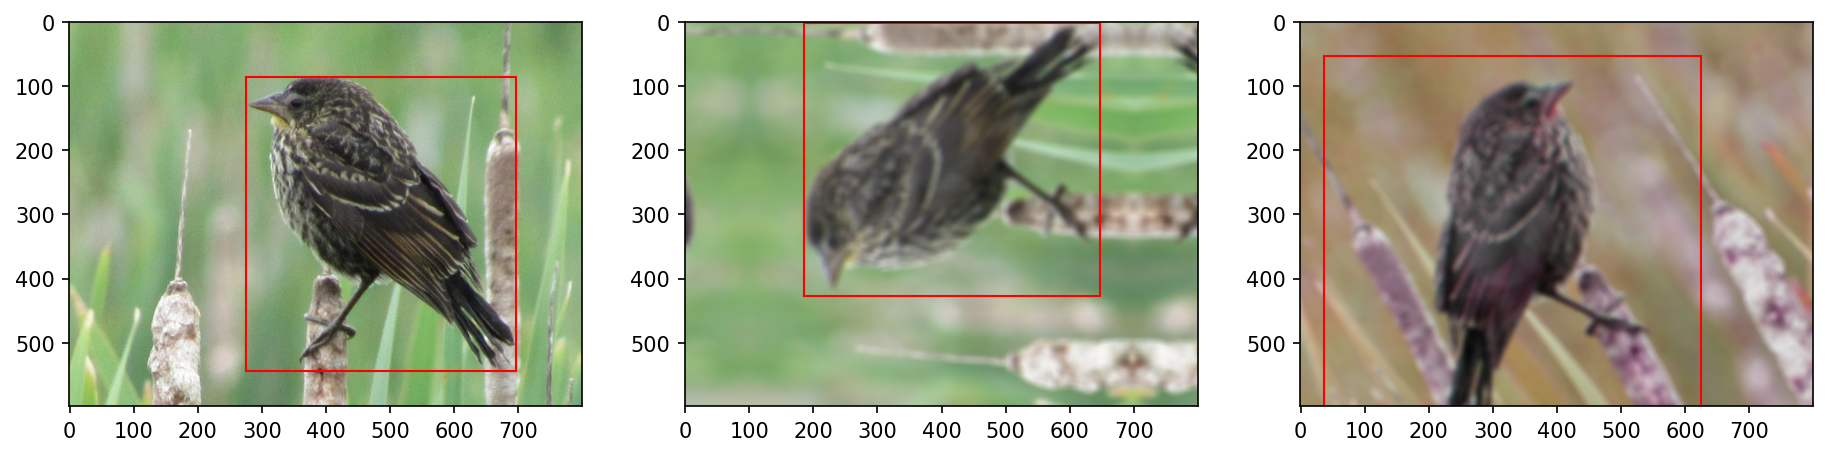

In [8]:
# visualizing a random image with its augementations
num = np.random.randint(1,len(train_augAves)//train_augAves.num_aug)
num *= 3

print("id:",num)

fig,ax = plt.subplots(1,train_augAves.num_aug,figsize=(15,10),dpi=150)

for i in range(train_augAves.num_aug):
    
    img, annot, _ = train_augAves[num+i]
    img = img.cpu().permute(1,2,0)

    ax[i].imshow(img)
    
    for idx in range(len(annot["boxes"])):
        
        xmin, ymin, xmax, ymax = annot["boxes"][idx]

        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='red',facecolor='none')

        ax[i].add_patch(rect)

plt.savefig('aug.png', transparent = True)

As you can see for the images above, for each image in the training dataset we decided to keep the original image, and then perform two additional transormations, both in terms of colors and rotation/flip of the image.

### 4.2 Dataloader - BW images <a class="anchor" id="bw_img"></a>

Again, to create the dataloader for the Black and White model, we decide to add in our dataset 2 albumentations augmentations while also keeping the original image (using the ```num_aug``` parameter). This time, however, the images given to the dataloader are black and white, located in the appropriate folder.

In [8]:
path_bw = "data_bw/images"

In [9]:
# defining the dataset class  and data loader for the train
train_augAves_bw = AvesAugmentationDataset(path_bw +'/Train', transform=transformations, df=train_df_final,num_aug=3)
train_data_loader_bw = torch.utils.data.DataLoader(train_augAves_bw, batch_size=16, collate_fn=collate_fn)

id: 4539
torch.Size([600, 800, 3])


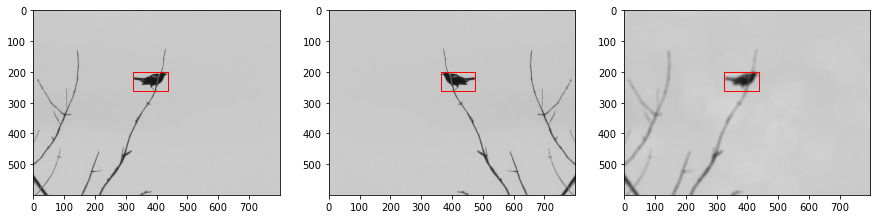

In [11]:
# visualizing a random image with its augementations
num = np.random.randint(1,len(train_augAves_bw)//train_augAves_bw.num_aug)
num *= 3

print("id:",num)

fig,ax = plt.subplots(1,train_augAves_bw.num_aug,figsize=(15,10))

for i in range(train_augAves_bw.num_aug):
    
    img, annot, _ = train_augAves_bw[num+i]
    img = img.cpu().permute(1,2,0)

    ax[i].imshow(img)
    
    for idx in range(len(annot["boxes"])):
        
        xmin, ymin, xmax, ymax = annot["boxes"][idx]

        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='red',facecolor='none')

        ax[i].add_patch(rect)

print(img.size())

Again, the first image shown above is the original one, while the second and third are the tranformed black and white images. In this case, reasonably, the only transformations applied are just geometric rotations.

### 4.3 Dataloader - Undersampled <a class="anchor" id="under_img"></a>

To create the dataloader using our custom sampler, we first need to save all the labels of our observations in order to feed them into the ```SATMsampler``` to let it be able to sample images according to their proportion in the original dataset. In this way we can provide images that are balanced across categories, considering a total number of images of 10000, thus removing some images from the most numerous classes

In [13]:
labels = []
for i in tqdm(os.listdir("data/images/Train")):
    annot = i[:-3] + "txt" 
    with open(f"data/labels/Train/{annot}", "r") as txt:
        for l in txt:
            labels.append(int(l[:2]))
            break
labels = pd.Series(labels)

  0%|          | 0/17805 [00:00<?, ?it/s]

In [14]:
path__= "data/images"

In [15]:
# defining the dataset class  and data loader for the train
train_augAves = AvesStochAugDataset(path__ +'/Train', transformations,
                                          train_df_final, labels, prop_aug=0.7)

under = 10000

sampler_under = SATMsampler(train_augAves, under, labels, num_aug=3)
train_data_loader_under = torch.utils.data.DataLoader(train_augAves, batch_size=16,
                                                      collate_fn=collate_fn, sampler = sampler_under)

Sampler size: 30000 (10000 x 3 augmentations)


### 4.4 Dataloader - Oversampled <a class="anchor" id="over_img"></a>

To create the dataloader using our custom sampler, we first need to save all the labels of our observations in order to feed them into the ```SATMsampler``` to let it be able to sample images according to their proportion in the original dataset. In this way we can provide images that are balanced across categories, considering a total number of images of 30000, sampling from the original dataset more images, proportionally to the numerosity of the classes.

In [15]:
path__= "data/images"

In [16]:
# defining the dataset class  and data loader for the train
train_augAves = AvesStochAugDataset(path__ +'/Train', transformations,
                                          train_df_final, labels, prop_aug=0.7)

over = 30000
sampler_over = SATMsampler(train_augAves, over, labels, num_aug=3)
train_data_loader_over = torch.utils.data.DataLoader(train_augAves, batch_size=16, 
                                                      collate_fn=collate_fn, sampler = sampler_over)

In [39]:
len(sampler_under.per_classes_samples[6])

612

## 5. FasterRCNN training <a class="anchor" id="tr"></a>
In this notebook we will perform transfer learning on our Aves datset, using Faster R-CNN, a two-stage detector.
We have frozen the backbone exploiting the pretrained weights, unfreezing the last three head layers. We also set the min_size and max_size parameters to 150 and 242 respectively, for computational reasons. In our case we have 11 classes, 10 bird categories plus one to include the background class. We will train each model for 4 epochs.

In [16]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,min_size=150,max_size=242)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [17]:
# defining the model
model = get_model_instance_segmentation(11)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(150,), max_size=242, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(i

In [18]:
# for all the model we will train 4 epochs and use the same parameters and optimizer
num_epochs = 4
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

### 5.1 Base Colored Model <a class="anchor" id="aug_m"></a>

The first setting we are using to train the model is the one with colored images and 3 augmentations. So, using the ```train_data_loader``` created above, we will input the data into the model in batches.

In [20]:
model_dir = "Model_Faster/Aug"

In [32]:
print('----------------------train start--------------------------')
for epoch in tqdm(range(num_epochs)):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations, _ in tqdm(train_data_loader):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    
    file = open(f"{model_dir}/model_epoch{epoch+1}.pkl", "wb")
    pickle.dump(model,file)
    file.close()
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3339 [00:00<?, ?it/s]

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch : 1, Loss : 825.92822265625, time : 5627.586881399155


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 2, Loss : 669.2989501953125, time : 5047.773880243301


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 3, Loss : 625.8775634765625, time : 5054.940503120422


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 4, Loss : 605.4271850585938, time : 5046.055244445801


### 5.2 BW Model <a class="anchor" id="bw_m"></a>

The second scenario is the one which takes as inputs the black & white images. Indeed, in this case the data loader used is ```train_data_loader_bw```. Again the model will be trained for 4 epochs.

In [21]:
model_dir = "Model_Faster/BW"

In [32]:
print('----------------------train start--------------------------')
for epoch in tqdm(range(num_epochs)):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations, _ in tqdm(train_data_loader_bw):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    
    file = open(f"{model_dir}/model_epoch{epoch+1}.pkl", "wb")
    pickle.dump(model,file)
    file.close()
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3339 [00:00<?, ?it/s]

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch : 1, Loss : 825.92822265625, time : 5627.586881399155


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 2, Loss : 669.2989501953125, time : 5047.773880243301


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 3, Loss : 625.8775634765625, time : 5054.940503120422


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 4, Loss : 605.4271850585938, time : 5046.055244445801


### 5.3 Undersampled Model <a class="anchor" id="under_m"></a>

Here we put again as inputs of the dataloader the colored images, but we are now using the sampler to resolve possible class imbalances. Thus, the total number of images (10.000) is a bit lower than before.

In [19]:
model_dir = "Model_Faster/Under30"

In [22]:
print('----------------------train start--------------------------')
for epoch in tqdm(range(num_epochs)):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in tqdm(train_data_loader_under):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    
    file = open(f"{model_dir}/model_epoch{epoch+1}.pkl", "wb")
    pickle.dump(model,file)
    file.close()
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Error in box width
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box height
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
epoch : 2, Loss : 328.44989013671875, time : 3084.5993325710297


  0%|          | 0/1875 [00:00<?, ?it/s]

Error in box width
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box height
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
epoch : 3, Loss : 325.76788330078125, time : 2754.026280641556


  0%|          | 0/1875 [00:00<?, ?it/s]

Error in box width
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box height
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
epoch : 4, Loss : 326.97552490234375, time : 2770.2915143966675


### 5.4 Oversampled Model <a class="anchor" id="over_m"></a>

The last setting we use to train our FasterR-CNN model is the oversampled one. In this case, using our ```SATMsampler``` we are sampling a bigger number of images (80.000) compared to the orginal dataframe but in a proportional way, solving possible imbalance problems between classes.

In [23]:
model_dir = "Model_Faster/Over"

In [24]:
print('----------------------train start--------------------------')
for epoch in tqdm(range(num_epochs)):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in tqdm(train_data_loader_over):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    
    file = open(f"{model_dir}/model_epoch{epoch+1}.pkl", "wb")
    pickle.dump(model,file)
    file.close()
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Error in box width
Error in box height
Error in box width
Error in box height
Error in box height
Error in box width
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
Error in box height
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
epoch : 1, Loss : 1012.1153564453125, time : 7961.283826351166


  0%|          | 0/5000 [00:00<?, ?it/s]

Error in box width
Error in box height
Error in box width
Error in box height
Error in box height
Error in box width
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
Error in box height
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
epoch : 2, Loss : 771.4262084960938, time : 7909.3546369075775


  0%|          | 0/5000 [00:00<?, ?it/s]

Error in box width
Error in box height
Error in box width
Error in box height
Error in box height
Error in box width
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
Error in box height
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
epoch : 3, Loss : 715.593505859375, time : 7894.80176115036


  0%|          | 0/5000 [00:00<?, ?it/s]

Error in box width
Error in box height
Error in box width
Error in box height
Error in box height
Error in box width
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
Error in box height
Error in box width
Error in box height
Error in box width
Error in box width
Error in box width
Error in box width
Error in box width
epoch : 4, Loss : 689.515869140625, time : 7908.805047512054
